In [48]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [49]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [50]:
from src.helpers import get_emotion_abrs_from_ids

# Paths

In [51]:
load_dotenv()
output_path = os.getenv("AUDIO_OUT")
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [52]:
exec(open(glob_conf_path).read())

# Load and shuffle data

In [53]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'audio_data_egemaps_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_1_id,filename,video_id,group
418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.350158,0.000000,0.449618,43,A101_sha_p_4,A101,0
343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.140063,0.000000,0.593075,27,A200_conc_p_1,A200,1
632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.226498,0.000000,0.552511,37,A101_disa_p_2,A101,0
512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.184858,0.000000,0.553816,30,A200_nos_p_1,A200,1
105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.315457,0.000000,0.453441,19,A102_ins_v_2,A102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0.682459,0.117735,0.667406,0.677529,0.656245,0.134158,0.056983,0.022535,0.176384,0.043100,...,0.207071,0.048689,0.197418,0.049422,0.253354,0.676849,25,A102_pea_p_3,A102,0
1317,0.809127,0.228207,0.782361,0.790750,0.788018,0.211168,0.051594,0.003829,0.140771,0.066234,...,0.172935,0.109551,0.251047,0.050852,0.359722,0.775907,20,A102_tri_p_2,A102,0
752,0.616353,0.194402,0.604902,0.614279,0.599872,0.136221,0.069463,0.023832,0.177081,0.054428,...,0.458385,0.101124,0.062252,0.006467,0.051345,0.778588,17,A200_dist_p_1,A200,1
543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.245426,0.000000,0.352454,41,A101_pri_v_3,A101,0


# Other functions

In [54]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [55]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [56]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [57]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [58]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Training and testing

### Get X, y and groups from the training data set

In [59]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Elastic Net SGD Classifier

### Grid Search best parameters

In [60]:
from sklearn.linear_model import SGDClassifier

# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 960 candidates, totalling 1920 fits
SGDClassifier(alpha=0.0005, class_weight='balanced', l1_ratio=0.3, loss='log',
              max_iter=2500, n_iter_no_change=50, penalty='elasticnet',
              random_state=27)


In [61]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,param_penalty,param_random_state,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
181,5.133241,0.109493,2.675463,0.008178,0.0005,balanced,0.3,log,2500,50,elasticnet,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.583958,0.587182,0.585570,0.001612,1
185,4.849282,0.138914,2.196492,0.006955,0.0005,balanced,0.35,log,2500,50,elasticnet,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.583320,0.587755,0.585537,0.002218,2
189,4.896397,0.200207,2.338707,0.119947,0.0005,balanced,0.4,log,2500,50,elasticnet,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.582232,0.588642,0.585437,0.003205,3


### Cross validate with best parameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing Area Under the Curve (AUC) measures
AUC_avg (train): 0.835709841366618
AUC_std (train): 0.033171604712283975
AUC_avg (validation): 0.585569805969959
AUC_std (validation): 0.0016122709541027125


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished


printing Unweighted Average Recall (UAC) measures
UAR_avg (train): 0.2435132575757576
UAR_std (train): 0.034706439393939414
UAR_avg (validation): 0.046306818181818185
UAR_std (validation): 0.007670454545454546


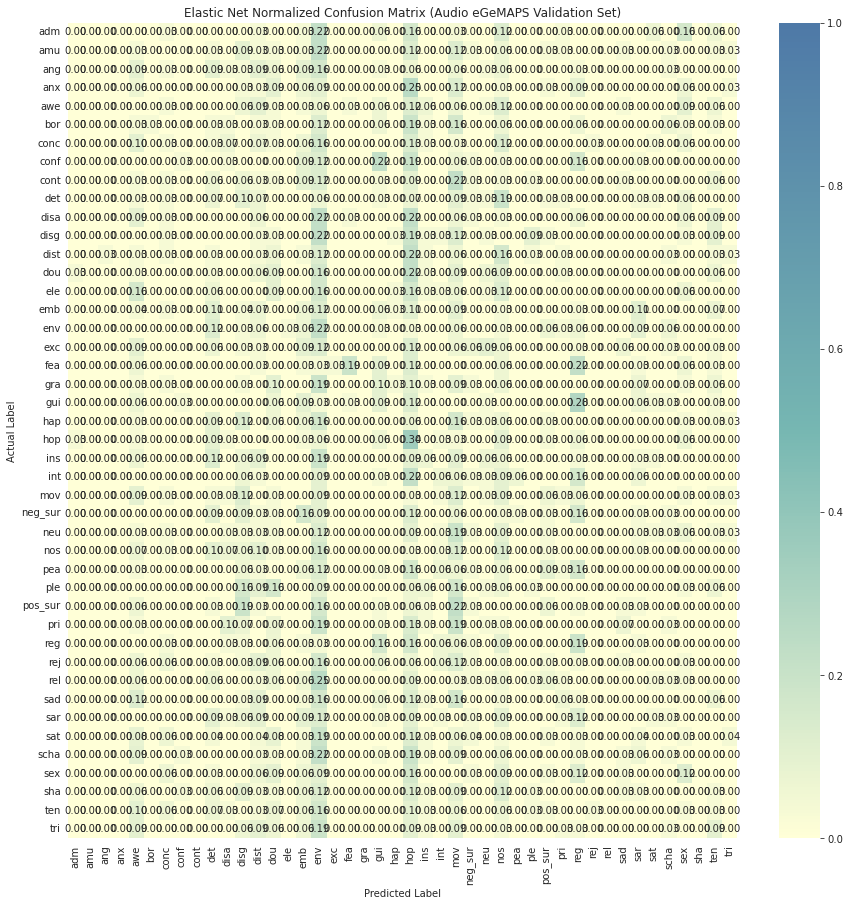

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

logo = LeaveOneGroupOut()

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

# get scores
scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('printing Area Under the Curve (AUC) measures')
print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True
                       )
      
print('printing Unweighted Average Recall (UAC) measures')
print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )

# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_egemaps_audio.svg')


# kNN Classifier

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

In [63]:
# we want to evaluate different number of neighbors (clusters) based on the size of the training set. 
# set a cluster floor at the number of targets 
floor = len(y.unique())
# set a cluster cap equal to 3/4:ths of the size of the training set.
# size of training set is equal to all datapoints minus the size of one group
cap = (len(y) - groups.value_counts().max()) * 3/4

n_neigh_values   = np.linspace(floor, cap, 50, dtype=np.int64).tolist()

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Define other to evaluate
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 450 candidates, totalling 900 fits
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=102)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


AUC_avg (train): 0.7283283619379175
AUC_std (train): 0.008769033185274833
AUC_avg (validation): 0.5606739154605092
AUC_std (validation): 0.0177908469483527
UAR_avg (train): 0.08641098484848486
UAR_std (train): 0.0016571969696969682
UAR_avg (validation): 0.04517045454545455
UAR_std (validation): 0.00028409090909090745


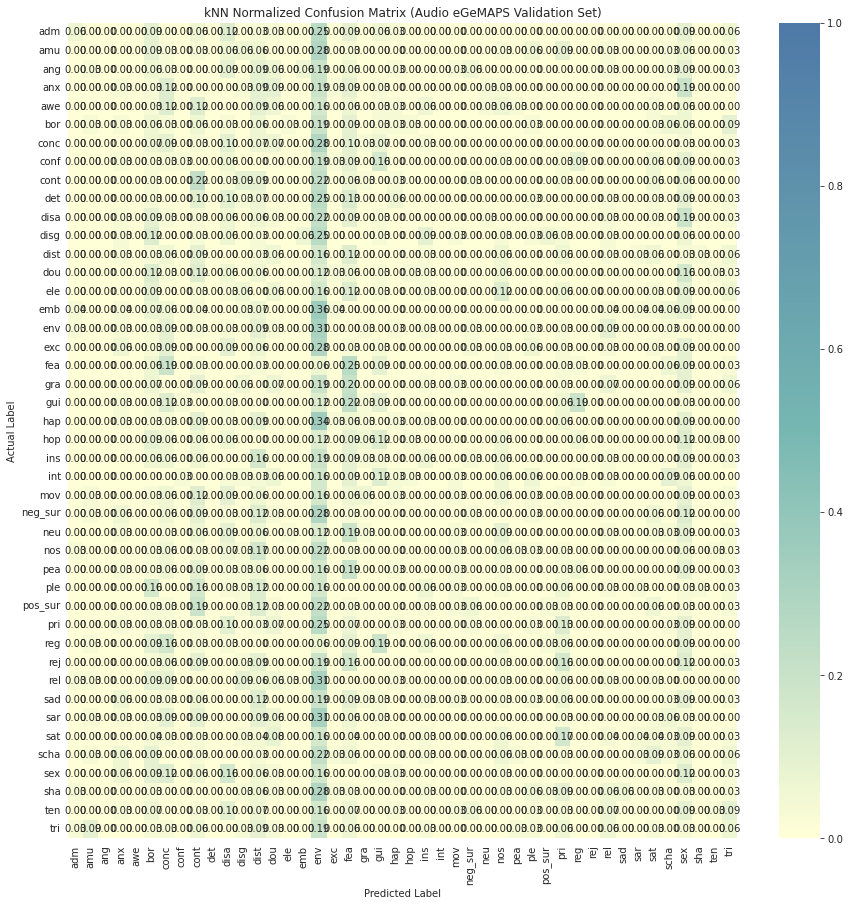

In [65]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )

# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_egemaps_audio.svg')

## Decision Tree


In [66]:
from sklearn.tree import DecisionTreeClassifier

# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features=62, min_samples_leaf=0.2,
                       min_samples_split=0.1, random_state=27)


In [67]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_class_weight,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
4424,0.088395,0.023609,2.790929,0.042216,best,27,0.2,0.2,62,35,entropy,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.541284,0.571112,0.556198,0.014914,1
1736,0.089189,0.018339,2.779087,0.032237,best,27,0.4,0.2,62,50,entropy,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.541284,0.571112,0.556198,0.014914,1
323,0.091441,0.019383,2.681352,0.046650,best,27,0.1,0.2,62,15,entropy,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.541284,0.571112,0.556198,0.014914,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


AUC_avg (train): 0.6791741965696902
AUC_std (train): 0.004383961368844613
AUC_avg (validation): 0.5561980367359429
AUC_std (validation): 0.014914011894505308
UAR_avg (train): 0.06363636363636363
UAR_std (train): 0.0011363636363636367
UAR_avg (validation): 0.03409090909090909
UAR_std (validation): 0.012784090909090908


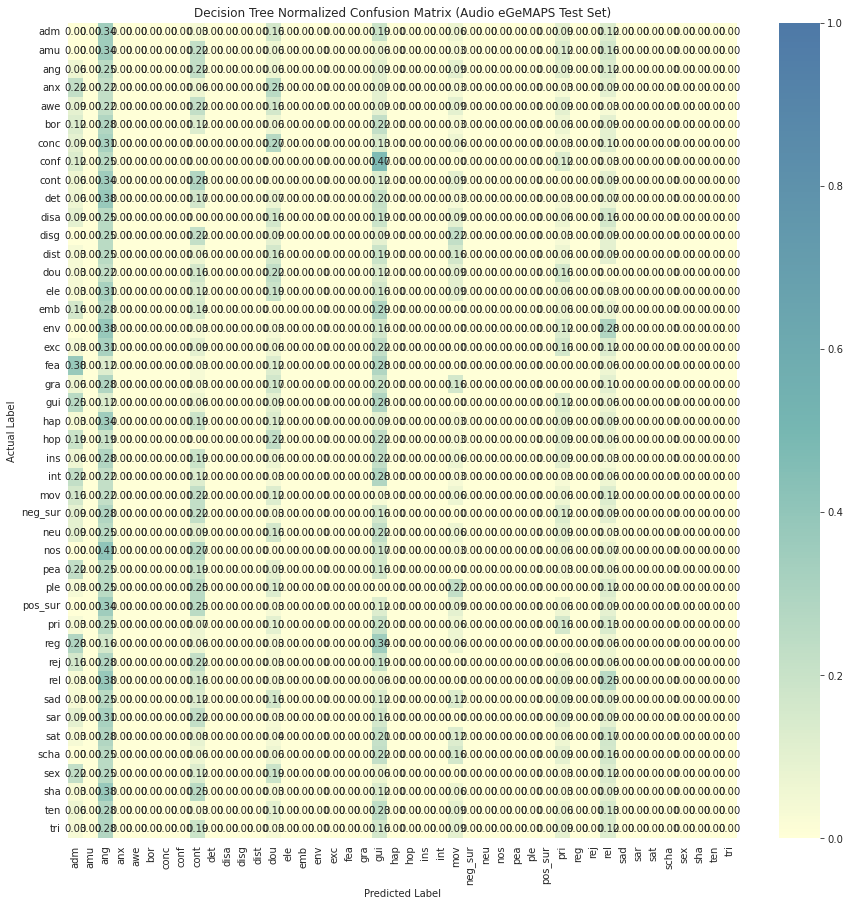

In [68]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Audio eGeMAPS Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_egemaps_audio.svg')

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Define parameters to evaluate
# the number of trees to build before taking the maximum voting or averages of predictions
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=178, n_jobs=-1, random_state=27)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


AUC_avg (train): 0.9995633782606104
AUC_std (train): 2.998106187895866e-05
AUC_avg (validation): 0.579447623857437
AUC_std (validation): 0.018129615466844995


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s finished


UAR_avg (train): 0.9836647727272727
UAR_std (train): 0.00639204545454547
UAR_avg (validation): 0.05075757575757576
UAR_std (validation): 0.002462121212121214


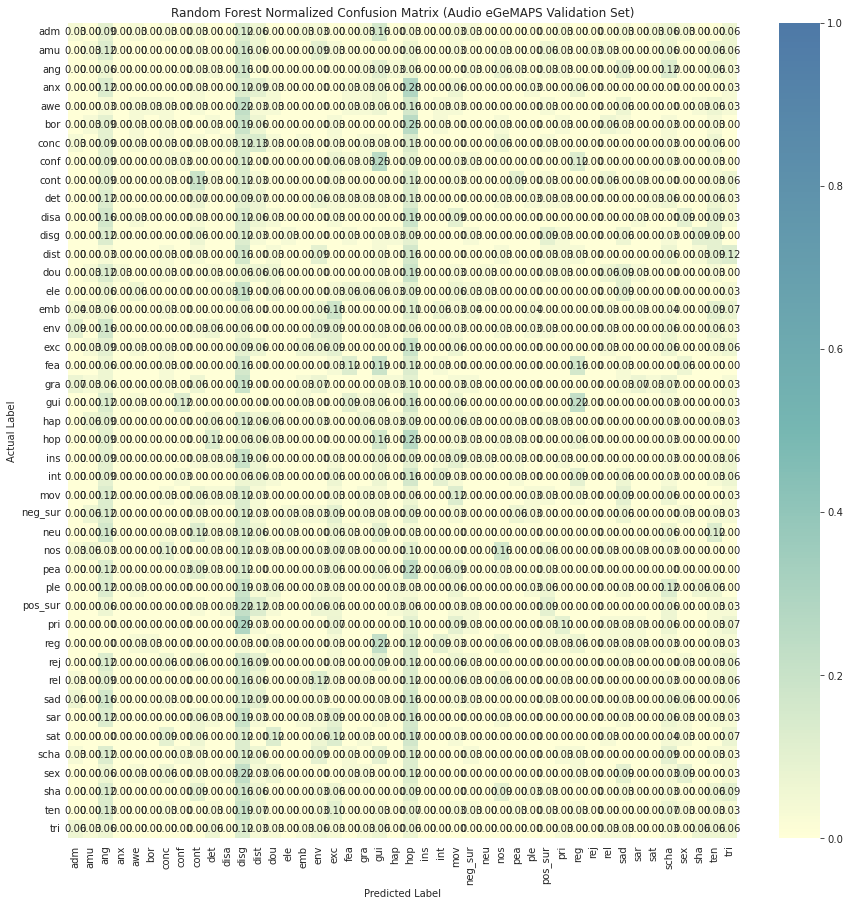

In [70]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_egemaps_audio.svg')